In [22]:
# Setup

%load_ext autoreload
%autoreload 2
%aimport

%matplotlib inline 

import matplotlib.pyplot as plt
import torch

from bliss.inference import SDSSFrame
from bliss.datasets import sdss
from bliss.inference import reconstruct_scene_at_coordinates
from case_studies.sdss_galaxies.plots.main import load_models


from astropy.table import Table

import plotly.express as px
import plotly.graph_objects as go

# check GPU is configured correctly
device = torch.device('cuda:0')
!echo $CUDA_VISIBLE_DEVICES

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:

5


In [23]:
# load models
from hydra import compose, initialize
from hydra.utils import instantiate
from bliss.encoder import Encoder

with initialize(config_path="../config"):
    cfg = compose("config", overrides=[])
    

In [24]:
single_prior = instantiate(cfg.datasets.sdss_galaxies.prior)
single_decoder = instantiate(cfg.datasets.sdss_galaxies.decoder)

In [25]:
from bliss.models.galsim_decoder import UniformGalsimGalaxiesPrior
prior = UniformGalsimGalaxiesPrior(single_prior, max_n_sources=5, max_shift=0.5)

In [135]:
# check samples look OK 
sample = prior.sample()

# COMMENT OUT for checking what happens when two sources fall in one tile
sample['locs'][1, :] = sample['locs'][0, :] + 0.01
print(sample)


{'n_sources': tensor(5), 'galaxy_params': tensor([[7.4521e+03, 5.1564e-01, 5.2357e-01, 7.2759e-01, 6.7483e+00, 7.3449e-01,
         6.2471e-01],
        [3.0327e+05, 1.3966e-01, 2.1316e-01, 7.2491e-01, 1.1813e+00, 4.3688e-01,
         5.3295e-01],
        [1.5551e+03, 6.6287e-01, 3.8017e+00, 1.3270e-01, 3.1606e+00, 5.6463e-01,
         4.2859e-01],
        [1.7635e+03, 7.8908e-01, 3.1282e+00, 6.8381e-01, 2.3593e+00, 4.2389e-01,
         1.6917e+00],
        [3.7242e+03, 1.2094e-01, 4.1292e+00, 8.1260e-01, 8.8961e-01, 7.3340e-01,
         4.2529e-01]]), 'locs': tensor([[0.0192, 0.4733],
        [0.0292, 0.4833],
        [0.9040, 0.6531],
        [0.7644, 0.5134],
        [0.6181, 0.4282]]), 'galaxy_bools': tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]]), 'star_bools': tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]])}


In [136]:
# now load full decoder
from bliss.models.galsim_decoder import GalsimGalaxiesDecoder
slen = 40
bp = 12
decoder = GalsimGalaxiesDecoder(single_decoder, slen, bp)

In [137]:
# turn sample to FullCatalog
from bliss.catalog import FullCatalog
params_dict = {**sample}
params_dict["plocs"] = params_dict["locs"] * slen
params_dict.pop('locs')
params_dict = {k: v.unsqueeze(0) for k, v in params_dict.items()}
full_cat = FullCatalog(slen, slen, params_dict)
print(full_cat['galaxy_bools'].shape)
print(full_cat.n_sources.shape)

torch.Size([1, 5, 1])
torch.Size([1])


In [138]:
tile_slen = 4
max_tile_n_sources = 1
tile_cat = full_cat.to_tile_params(tile_slen, max_tile_n_sources)
tile_cat['galaxy_bools'].shape

torch.Size([1, 10, 10, 1, 1])

In [139]:
images, centered, uncentered = decoder(full_cat)

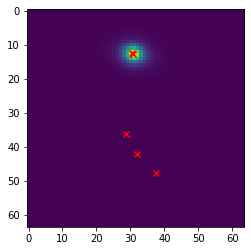

In [140]:
plocs_numpy = full_cat.plocs.numpy()
n_sources = full_cat.n_sources.item()
plt.imshow(images[0, 0].numpy())
plt.scatter(plocs_numpy[0, :n_sources, 1] + decoder.bp - 0.5, plocs_numpy[0, :n_sources, 0] + decoder.bp - 0.5, marker='x', c='r')

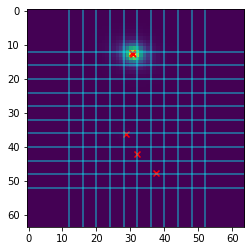

In [141]:
# tiles (blue squares)
plocs_numpy = full_cat.plocs.numpy()
n_sources = full_cat.n_sources.item()
plt.imshow(images[0, 0].numpy())
plt.scatter(plocs_numpy[0, :n_sources, 1] + decoder.bp - 0.5, plocs_numpy[0, :n_sources, 0] + decoder.bp - 0.5, marker='x', c='r')
for x,y in zip(np.arange(0, slen+tile_slen, tile_slen) + bp, np.arange(0, slen+tile_slen, tile_slen) + bp): 
    plt.axvline(x, c='cyan', alpha=0.5)
    plt.axhline(y, c='cyan', alpha=0.5)

In [142]:
tile_cat.n_sources # should correspond to above squares

tensor([[[0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]]])

In [147]:
tile_cat['galaxy_params'][0, :, :, 0, 0] # should correspond to above squares

tensor([[     0.0000,      0.0000,      0.0000,      0.0000, 303266.7500,
              0.0000,      0.0000,      0.0000,      0.0000,      0.0000],
        [     0.0000,      0.0000,      0.0000,      0.0000,      0.0000,
              0.0000,      0.0000,      0.0000,      0.0000,      0.0000],
        [     0.0000,      0.0000,      0.0000,      0.0000,      0.0000,
              0.0000,      0.0000,      0.0000,      0.0000,      0.0000],
        [     0.0000,      0.0000,      0.0000,      0.0000,      0.0000,
              0.0000,      0.0000,      0.0000,      0.0000,      0.0000],
        [     0.0000,      0.0000,      0.0000,      0.0000,      0.0000,
              0.0000,      0.0000,      0.0000,      0.0000,      0.0000],
        [     0.0000,      0.0000,      0.0000,      0.0000,      0.0000,
              0.0000,      0.0000,      0.0000,      0.0000,      0.0000],
        [     0.0000,      0.0000,      0.0000,      0.0000,   3724.2180,
              0.0000,      0.000

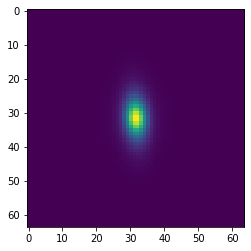

In [110]:
plt.imshow(centered[0, 2, 0].numpy())

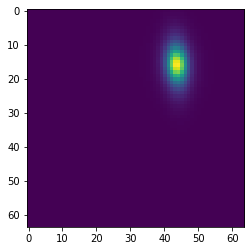

In [111]:
plt.imshow(uncentered[0, 2, 0].numpy())

In [151]:
# now dataset 
from bliss.datasets.galsim_galaxies import GalsimBlends
from bliss.datasets.background import ConstantBackground
background = ConstantBackground((860.,))
ds = GalsimBlends(prior, decoder, background, tile_slen, max_tile_n_sources, num_workers=0, batch_size=5, n_batches=2)

In [152]:
# get one sample from dataset
print(ds[0]['galaxy_bools'].shape)
print(ds[0]['n_sources'].shape)

torch.Size([10, 10, 1, 1])
torch.Size([10, 10])


torch.Size([5, 10, 10])
torch.Size([5, 1, 64, 64])

torch.Size([5, 10, 10])
torch.Size([5, 1, 64, 64])



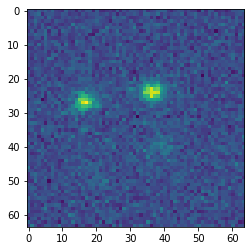

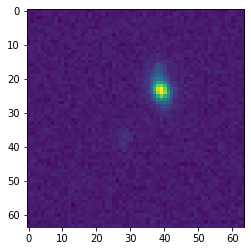

In [158]:
# now a batch 
for x in ds.train_dataloader():
    print(x['n_sources'].shape)
    print(x['images'].shape)
    print()
    plt.figure()
    plt.imshow(x['images'][0, 0].numpy())